# Emoji Classifier


Goal: pick the best emoji to use based on words/phrases


In [ ]:
#load
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data


Dataset from Hugging face
80 - 10-10 train/val/test split

6 classes of emotions/sentiment


0.   Sadness
1.   Joy
2. Love
3. Anger
4. Fear
5. Surprise




### Fix Data Imbalance


In [ ]:
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df_1 = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_2 = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
df_3 = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])
df = pd.concat([df_1,df_2,df_3], axis = 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(array([5797.,    0., 6761.,    0., 1641.,    0., 2709.,    0., 2373.,
         719.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

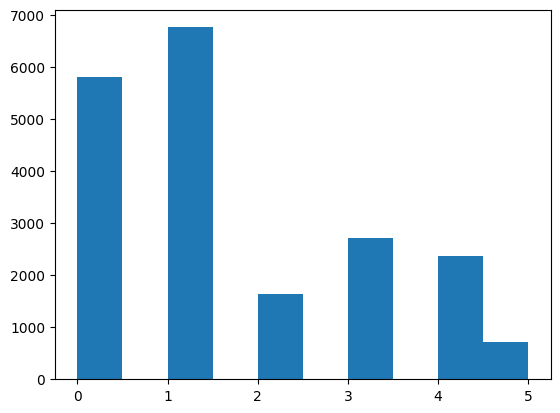

In [ ]:
plt.hist(df['label'])

In [ ]:
love = pd.read_csv("/content/drive/MyDrive/emoji_classifier/csvs/love_messages_clean.csv")
fear = pd.read_csv("/content/drive/MyDrive/emoji_classifier/csvs/fear_messages_clean.csv")
anger = pd.read_csv("/content/drive/MyDrive/emoji_classifier/csvs/anger_messages_clean.csv")
surprise = pd.read_csv("/content/drive/MyDrive/emoji_classifier/csvs/surprise_messages_clean.csv")

In [ ]:
df = pd.concat([df, love, fear, surprise,anger], axis = 0)
df = df.sample(frac = 1)

### Train-val-test split


In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Word Processing


### Remove stop words


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def remove_stop_words(phrase):
    word_tokens = word_tokenize(phrase)
    filtered_words = [w for w in word_tokens if w.lower() not in stopwords]
    return " ".join(filtered_words)

In [ ]:
df_train_cleaned = X_train
df_val_cleaned = X_val
df_test_cleaned = X_test

for i in range(len(X_train)):
  df_train_cleaned.iloc[i] = remove_stop_words(X_train.iloc[i])
for i in range(len(X_val)):
  df_val_cleaned.iloc[i] = remove_stop_words(X_val.iloc[i])
for i in range(len(X_test)):
  df_test_cleaned.iloc[i] = remove_stop_words(X_test.iloc[i])

### Vectorization


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train_cleaned)
X_val = vectorizer.transform(df_val_cleaned)
X_test = vectorizer.transform(df_test_cleaned)

## Logistic Regression Model


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.9316666666666666

## Rf


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators = 100, max_depth = 40, min_samples_leaf= 10, random_state = 15)
model1.fit(X_train,y_train)

y_pred = model1.predict(X_val)

accuracy_score(y_val, y_pred)

0.7366666666666667

In [ ]:
print(accuracy_score(y_test, model1.predict(X_test)))
print(accuracy_score(y_train, model1.predict(X_train)))

0.7522222222222222
0.7626736111111111


### RNN


In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


In [ ]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 100000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that', 'my',
       'of', 'feeling', 'im', 'in', 'me', 'like', 'this', 'so', 'is',
       'it'], dtype='<U74')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'didnt see that one coming at all'
 b'i feel that time frame is going properly i m keen on you plenty probably we could repeat this once more and then the lady may possibly grin at you as well as claim the girl loves as well'
 b'im so grateful for your love']

labels:  [5 1 2]


In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 67s 128ms/step - accuracy: 0.3540 - loss: 2.4736 - val_accuracy: 0.5505 - val_loss: 1.7515
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 181ms/step - accuracy: 0.5779 - loss: 1.6134 - val_accuracy: 0.6411 - val_loss: 1.2036
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.6377 - loss: 1.1770 - val_accuracy: 0.6646 - val_loss: 1.0209
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - accuracy: 0.6640 - loss: 1.0050 - val_accuracy: 0.7245 - val_loss: 0.8769
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - accuracy: 0.7380 - loss: 0.8268 - val_accuracy: 0.7781 - val_loss: 0.7471
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 115ms/step - accuracy: 0.8135 - loss: 0.6650 - val_accuracy: 0.8401 - val_loss: 0.6345
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.8779 - loss: 0.5296 - val_accuracy: 0.8760 - val_loss: 0.5439
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 57s 127ms/step - accuracy: 0.9195 - loss: 0

In [ ]:
from google.colab import files
model.save('emoji_classifier_rnn_model.keras')
files.download("emoji_classifier_rnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8992 - loss: 0.4389
Test Loss: 0.4465661346912384
Test Accuracy: 0.894444465637207


(0.0, 2.3633506491780283)

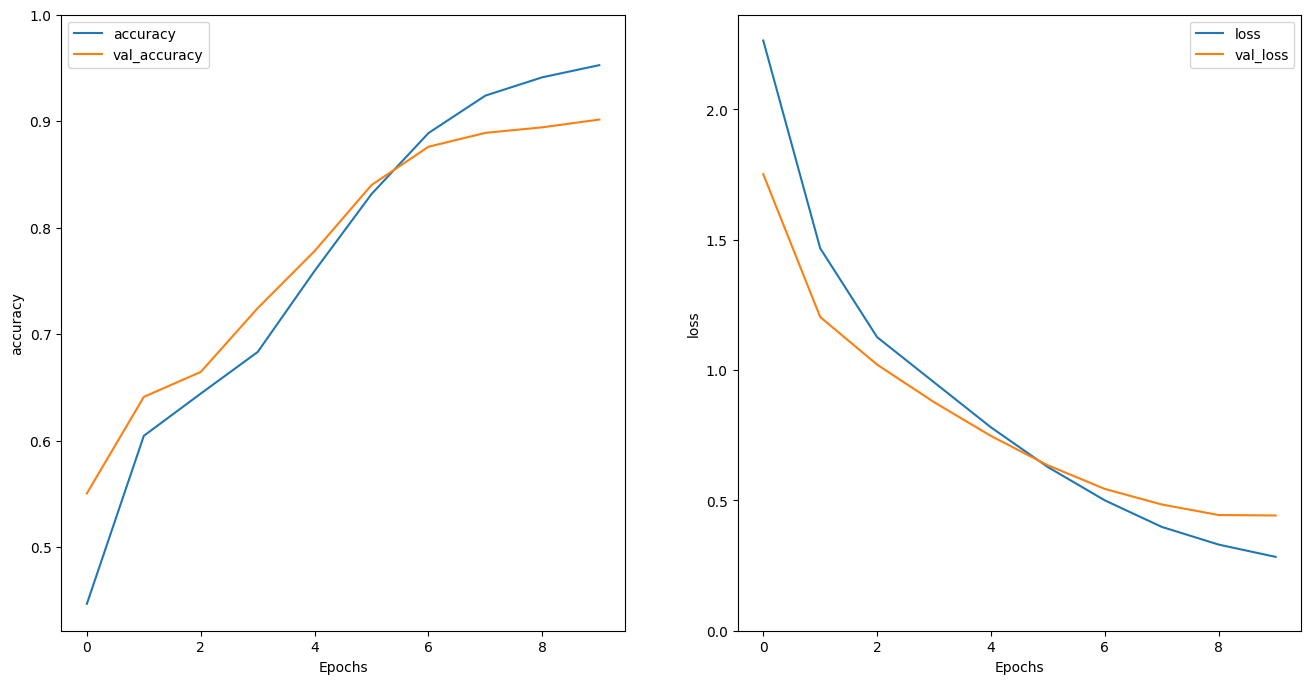

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
def preprocessing(word):
  word_v = vectorizer.transform([word])
  return word_v

In [ ]:
import random
from PIL import Image
def emojify(label):
  random_emoji = random.randint(0, 2)
  match label:
    case 0:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/pensive.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/cry.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/sob.png')
    case 1:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/smile.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/hugging_face.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/Omar.png')
    case 2:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/smiling_face_with_three_hearts.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/heart_eyes.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/heart.png')
    case 3:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/angry.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/rage.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/imp.png')
    case 4:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/fearful.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/scream.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/grimacing.png')
    case 5:
      match random_emoji:
        case 0:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/open_mouth.png')
        case 1:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/face_with_hand_over_mouth.png')
        case 2:
          img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/speak_no_evil.png')
  plt.figure(figsize=(0.2, 0.2))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
user_input = input("Enter some text: ")
print("You entered:", user_input)

Enter some text: I am so happy
You entered: I am so happy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


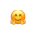

In [ ]:
def predict_user_input(text):
    # Wrap in a batch
    input_tensor = tf.constant([text])
    prediction = model.predict(input_tensor)
    predicted_class = np.argmax(prediction[0])
    emojify(predicted_class)

predict_user_input(user_input)

In [ ]:
y_pred = model.predict(test_dataset)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


In [ ]:
import random
from PIL import Image
def emojify_test(label):
  random_emoji = random.randint(0, 2)
  match label:
    case 0:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/sob.png')
    case 1:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/smile.png')
    case 2:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/heart.png')
    case 3:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/rage.png')
    case 4:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/scream.png')
    case 5:
      img = Image.open('/content/drive/MyDrive/emoji_classifier/emojis/open_mouth.png')
  plt.figure(figsize=(0.2, 0.2))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
for batch in test_dataset:
  inputs, labels = batch
  for i in range(labels.shape[0]):
    predicted_class = np.argmax(y_pred[i])
    print(f"Input text (raw): {X_test.iloc[i]}")
    print(f"Predicted label: {predicted_class}")
    print(f"True label: {labels[i].numpy()}")
    emojify_test(predicted_class)
    emojify_test(labels[i].numpy())

Input text (raw): i spent saturday night and all of sunday feeling pretty lousy
Predicted label: 0
True label: 0


NameError: name 'emojify_test' is not defined

In [ ]:
import csv
rows = []
index = 0
for batch in test_dataset:
    inputs, labels = batch
    for i in range(labels.shape[0]):
        predicted_class = np.argmax(y_pred[index])
        true_label = labels[i].numpy()
        input_text = X_test.iloc[index]
        rows.append([input_text, predicted_class, true_label])
        index += 1

with open("test_predictions.csv", mode="w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Input Text", "Predicted Label", "True Label"])
    writer.writerows(rows)

print("Saved test_predictions.csv successfully.")


Saved test_predictions.csv successfully.
